# # Machine Learning I

Pratical Assignment

Alexandre Sousa - 202206427

Guilherme Oliveira - 

Mario Minhava - 


In [537]:
import openml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from collections import Counter
from scipy.stats import f_oneway
from sklearn.utils import resample
import numpy as np 
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed


# FUNCOES DE DISTÂNCIA


In [538]:
distance_functions = [euclidean_distance, manhattan_distance, cosine_distance, minkowski_distance, hamming_distance, jaccard_distance] 

def euclidean_distance(p1, p2):
    P1 = np.array(p1)
    P2 = np.array(p2)
    temp = P1 - P2
    euclid_dist = np. sqrt(np.dot(temp.T, temp))
    return euclid_dist

def manhattan_distance(p, q):
    return np.sum(np.abs(p - q))

def minkowski_distance(p, q, order=3):
    return np.power(np.sum(np.abs(p - q)**order), 1 / order)

def chebyshev_distance(p, q):
    return np.max(np.abs(p - q))

def hamming_distance(p, q):
    return np.sum(p != q) / len(p)

def jaccard_distance(p, q):
    p = np.asarray(p, np.bool_) # Converte para booleano se ainda não for
    q = np.asarray(q, np.bool_)
    return 1 - np.double(np.bitwise_and(p, q).sum()) / np.double(np.bitwise_or(p, q).sum())


def cosine_distance(p, q):
    return 1 - np.dot(p, q) / (np.linalg.norm(p) * np.linalg.norm(q))


def mahalanobis_distance(p, q, cov=None):
    # Ensure p and q are at least 2D arrays with shape (1, n_features)
    p = np.atleast_2d(p)
    q = np.atleast_2d(q)

    # Calculate the covariance matrix if not provided
    if cov is None:
        combined = np.vstack([p, q])  # Combine p and q vertically
        cov = np.cov(combined, rowvar=False)  # Calculate covariance matrix of columns
        if cov.shape == (1, 1):  # Handle edge case for single-feature data
            cov = cov + np.eye(1) * 1e-10

    # Add a small noise to the diagonal elements to prevent singular matrix issues
    cov += np.eye(cov.shape[0]) * 1e-10

    # Compute the inverse of the covariance matrix
    try:
        inv_covmat = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        inv_covmat = np.linalg.pinv(cov)  # Use pseudoinverse as fallback

    delta = p - q
    return np.sqrt(np.dot(np.dot(delta, inv_covmat), delta.T))[0, 0]

# Encontrar o melhor K

In [539]:
def find_best_k(X_train, X_test, y_train, y_test):
    # Testando diferentes valores de K
    Ks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    accs = []
    for k in Ks:
        KNNteste=KNNBase(k)
        KNNteste.fit(X_train,y_train)
        predictions =KNNteste._predict(X_test)
        accuracy = np.mean(predictions == y_test)
        accs.append(accuracy)
    # Encontrando o melhor valor de K
    best_k = Ks[accs.index(max(accs))]
    return best_k


def find_best_k_bagging(X_train, X_test, y_train, y_test, distance_funcs = distance_functions):
    # Testando diferentes valores de K
    Ks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    accs = []
    for k in Ks:
        KNNteste=KNN_Bagging(k=k, n_estimators=10,distance_funcs=distance_functions)
        KNNteste.fit(X_train,y_train)
        predictions =KNNteste.predict(X_test)
        accuracy = np.mean(predictions == y_test)
        accs.append(accuracy)
    # Encontrando o melhor valor de K
    best_k = Ks[accs.index(max(accs))]
    return best_k

 # KNN BASE

In [540]:
from collections import Counter
import numpy as np
from scipy.spatial.distance import euclidean

class KNNBase():
    def __init__(self, k=5, distance_func = euclidean_distance, mode='classification'):
        """Base class for Nearest neighbors classifier and regressor.

        Parameters
        ----------
        k : int, default 5
            The number of neighbors to take into account. If 0, all the
            training examples are used.
        distance_func : function, default euclidean distance
            A distance function taking two arguments. Any function from
            scipy.spatial.distance will do.
        mode : str, default 'classification'
            The mode of operation for aggregation. Either 'classification' or 'regression'.
        """

        self.k = None if k == 0 else k  # l[:None] returns the whole list
        self.distance_func = distance_func
        self.mode = mode

    def aggregate(self, neighbors_targets):
        if self.mode == 'classification':
            # Using Counter to find the most common class among the nearest neighbors
            most_common = Counter(neighbors_targets).most_common(1)
            return most_common[0][0]
        elif self.mode == 'regression':
            # Calculating the mean of the targets for regression purposes
            return np.mean(neighbors_targets)
        else:
            raise ValueError("Unsupported mode. Use 'classification' or 'regression'.")

    def _predict(self, X):
        X = np.array(X)
        predictions = [self._predict_x(x) for x in X]
        return np.array(predictions)

    def _predict_x(self, x):
        # Garante que x é um array 1-D
        x = np.array(x).ravel()

        # Calcula as distâncias entre x e todos os exemplos no conjunto de treinamento
        distances = [self.distance_func(x, example.ravel()) for example in self.X]

        # Ordena todos os exemplos pela distância até x e mantém o valor alvo
        neighbors = sorted(zip(distances, self.y), key=lambda pair: pair[0])

        # Obtém os alvos dos k vizinhos mais próximos e agrega-os
        neighbors_targets = [target for _, target in neighbors[:self.k]]

        return self.aggregate(neighbors_targets)

    def fit(self, X, y):
        """Store the training dataset."""
        self.X = np.array(X)
        self.y = np.array(y)


# KNN - BAGGING

In [541]:
class KNN_Bagging:
    def __init__(self, k=5, n_estimators=10, distance_funcs=None, distance_weights=None, max_features=1.0, n_jobs=None):
        self.k = k
        self.n_estimators = n_estimators
        self.distance_funcs = distance_funcs if distance_funcs else [euclidean_distance] * n_estimators
        self.distance_weights = distance_weights if distance_weights else [1] * n_estimators
        self.max_features = max_features  # Fraction of features to use for each model
        self.models = []
        self.feature_indices = []  # To store indices of features for each model
        self.n_jobs = n_jobs

    def fit(self, X, y):
            n_features = X.shape[1]
            n_sub_features = int(self.max_features * n_features) if self.max_features <= 1.0 else self.max_features
            tasks = []

            for i in range(self.n_estimators):
                features_idx = np.random.choice(n_features, n_sub_features, replace=False)
                self.feature_indices.append(features_idx)
                X_sample, y_sample = resample(X[:, features_idx], y)
                task = delayed(self.train_model)(X_sample, y_sample, self.distance_funcs[i % len(self.distance_funcs)], self.k)
                tasks.append(task)

            self.models = Parallel(n_jobs=self.n_jobs)(tasks)

    def predict(self, X):
        final_predictions = []

        # Each instance needs its votes aggregated from all models
        for i in range(X.shape[0]):
            # Use a Counter to sum up the weighted votes for the current instance across all models
            weighted_vote_counts = Counter()

            for model, features_idx, weight in zip(self.models, self.feature_indices, self.distance_weights):
                # Predict using the stored feature indices for each model
                pred = model._predict(X[:, features_idx])[i]  # Get prediction for the i-th instance
                weighted_vote_counts[pred] += weight  # Weight is added to the count of the predicted class

            # If no votes were cast, handle it (perhaps return a default or most common class)
            if not weighted_vote_counts:
                print("Warning: No votes cast for instance index", i)
                final_predictions.append(None)  # Or handle as required
            else:
                # Determine the majority vote based on weights
                final_predictions.append(weighted_vote_counts.most_common(1)[0][0])

        return np.array(final_predictions)
    
    def train_model(self, X_sample, y_sample, distance_func, k):
        model = KNNBase(k=k, distance_func=distance_func)
        model.fit(X_sample, y_sample)
        return model

    
    

Vamos analisar os 10 data sets com o código base: 
Temos de testar em especifico duas coisas: 
 - Noise
 - Class overlap 

In [542]:
def split_data(df, test_size=0.2):
    # Assuming the last column is the target variable
    X = df.iloc[:, :-1].values  # all rows, all columns except the last
    y = df.iloc[:, -1].values   # all rows, just the last column
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

# Treino de Dados


In [543]:
def treino_knn_base(dataset,k):
    splits_ds1 = split_data(dataset)
    #Knn-base -> Funcão de distancia euclidean 
    k = find_best_k(splits_ds1[0],splits_ds1[1], splits_ds1[2], splits_ds1[3])
    
    knn_base = KNNBase(k = k)
    knn_base.fit(splits_ds1[0], splits_ds1[2])
    y_pred_ds1 = knn_base._predict(splits_ds1[1])

    le = LabelEncoder()
    y_teste = le.fit_transform(splits_ds1[3]) #y de teste
    
    print("Classes present in training data:", le.classes_)
    
    previsoes = le.transform(y_pred_ds1) #previsoes 
    
    print("Unique labels predicted:", np.unique(previsoes))
    
    return y_teste, previsoes
    

def treino_knn_bagging(dataset, k, n_estimators=10, distance_funcs=distance_functions):
    splits_ds = split_data(dataset)
    k = find_best_k_bagging(splits_ds[0], splits_ds[1], splits_ds[2], splits_ds[3], distance_functions)
    print("SAI DAQUI+")
    print("O melhor k encontrado é: ", k)
    
    # Pass the list of distance functions to the KNN_Bagging constructor
    knn_bagging = KNN_Bagging(k=k, n_estimators=n_estimators, distance_funcs=distance_funcs)
    knn_bagging.fit(splits_ds[0], splits_ds[2])
    
    le = LabelEncoder()
    y_teste = le.fit_transform(splits_ds[3])  # Transform y of test to numeric format
    print("Classes present in training data:", le.classes_)
    
    predictions = knn_bagging.predict(splits_ds[1])
    transformed_predictions = le.transform(predictions)  # Transform predictions to the original label format
    print("Unique labels predicted:", np.unique(transformed_predictions))
    
    return transformed_predictions, y_teste
    



# Funcões de Estatistica 

In [544]:
def plot_roc_curve(y_test, y_score, n_classes):
    # Binarize the output labels for multiclass
    y_test_bin = label_binarize(y_test, classes=[*range(n_classes)])
    
            
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    

    
def print_classification_report(y_test, y_pred):
    report = classification_report(y_test, y_pred)
    print(report)

 # DATASET 1

### KNN BASE

Classes present in training data: ['tested_negative' 'tested_positive']
Unique labels predicted: [0 1]
              precision    recall  f1-score   support

           0       0.73      0.87      0.79        99
           1       0.64      0.42      0.51        55

    accuracy                           0.71       154
   macro avg       0.68      0.64      0.65       154
weighted avg       0.70      0.71      0.69       154



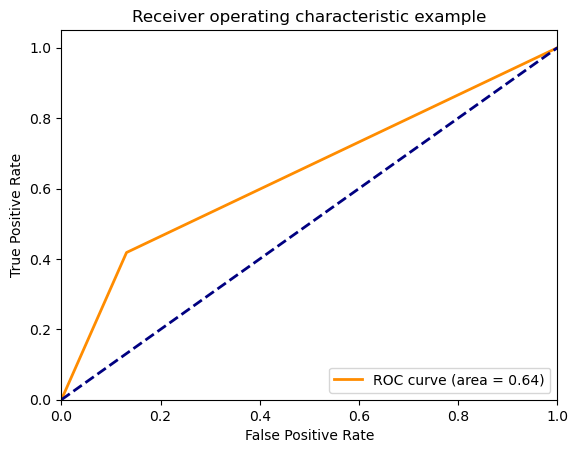

In [545]:
df_ds1 = pd.read_csv("csv_result-dataset_diabetes_35.csv")


y_true,y_pred = treino_knn_base(df_ds1,3)


print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)


# KNN - BAGGING 

In [ ]:

y_pred,y_true = treino_knn_bagging(df_ds1,3)

print(y_pred)
print(y_true)


print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)

# DATA SET 2


 # KNN Base

In [ ]:
df_ds2 = pd.read_csv("heart_statlog_cleveland_hungary_final.csv")

y_true,y_pred = treino_knn_base(df_ds2,3)


print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)

In [ ]:
y_pred,y_true = treino_knn_bagging(df_ds2,3)

print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)


# DATA SET 3


KNN Base


In [ ]:
dataset = openml.datasets.get_dataset(1066)
X, y, _, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
df_ds3 = pd.DataFrame(X, columns=attribute_names)
df_ds3[dataset.default_target_attribute] = y



In [ ]:
y_true,y_pred = treino_knn_base(df_ds3,2)


print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)

knn bagging

In [ ]:
y_pred,y_true = treino_knn_bagging(df_ds3,2)



print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)

# DATA SET 4


KNN BASE

In [ ]:
dataset = openml.datasets.get_dataset(967)
X, y, _, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
df_ds4 = pd.DataFrame(X, columns=attribute_names)
df_ds4[dataset.default_target_attribute] = y
df_ds4['cylinders'] = pd.to_numeric(df_ds4['cylinders'])
df_ds4 = df_ds4.drop(df_ds4.columns[0], axis=1) 
y_true,y_pred = treino_knn_base(df_ds4,2)

print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)

knn bagging

In [ ]:
y_pred,y_true = treino_knn_bagging(df_ds4,3)


print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)

# DATA SET 5

KNN BASE


In [ ]:
dataset = openml.datasets.get_dataset(964)
X, y, _, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
df_ds5= pd.DataFrame(X, columns=attribute_names)
df_ds5[dataset.default_target_attribute] = y

df_encoded = pd.get_dummies(df_ds5, drop_first=True) 
y_true,y_pred = treino_knn_base(df_encoded,3)
#Teste Negativo -> 0 Teste Positivo -> 1

print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)

knn bagging

In [ ]:

y_pred,y_true = treino_knn_bagging(df_encoded,5)


print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)

# DATA SET 6

KNN BASE

In [ ]:
dataset = openml.datasets.get_dataset(970)
X, y, _, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
df_ds6 = pd.DataFrame(X, columns=attribute_names)
df_ds6[dataset.default_target_attribute] = y

y_true,y_pred = treino_knn_base(df_ds6,3)
#Teste Negativo -> 0 Teste Positivo -> 1

print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)

## knn bagging

In [ ]:
y_pred,y_true = treino_knn_bagging(df_ds6,3)

print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)

FALTAM 4 DATA SETS...


# DATA SET 7

KNN BASE

In [ ]:
dataset = openml.datasets.get_dataset(975)
X, y, _, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
df_ds7 = pd.DataFrame(X, columns=attribute_names)
df_ds7[dataset.default_target_attribute] = y
# Convert categorical variable into dummy/indicator variables.
df_encoded = pd.get_dummies(df_ds7, drop_first=True)  # drop_first=True to avoid multicollinearity
print(df_encoded.head())

y_true,y_pred = treino_knn_base(df_encoded,3)
#Teste Negativo -> 0 Teste Positivo -> 1

print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)

In [ ]:
y_pred,y_true = treino_knn_bagging(df_encoded,3)

print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)

# DATA SET 8

In [ ]:
dataset = openml.datasets.get_dataset(1009)
X, y, _, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
df_ds7 = pd.DataFrame(X, columns=attribute_names)
df_ds7[dataset.default_target_attribute] = y

df_encoded = pd.get_dummies(df_ds7, drop_first=True)  # drop_first=True to avoid multicollinearity
print(df_encoded.head())
y_true,y_pred = treino_knn_base(df_encoded,3)
#Teste Negativo -> 0 Teste Positivo -> 1

print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)

In [ ]:
y_pred,y_true = treino_knn_bagging(df_encoded,3)

print_classification_report(y_true, y_pred)
plot_roc_curve(y_true,y_pred,2)